In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [26]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [27]:
print("Loading the imputed PhysioNet Heart Failure dataset...")
df = pd.read_csv('imputed_original.csv')
print(f"Dataset shape: {df.shape}")

Loading the imputed PhysioNet Heart Failure dataset...
Dataset shape: (2008, 40)


In [28]:
df.head()

,verbal.response,eye.opening,movement,GCS,lactate.dehydrogenase,glutamic.oxaloacetic.transaminase,globulin,total.bilirubin,direct.bilirubin,indirect.bilirubin,...,eosinophil.ratio,eosinophil.count,basophil.ratio,basophil.count,creatinine.enzymatic.method,cystatin,sodium,chloride,systolic.blood.pressure,re.admission.within.6.months
0,5,4,6,15,294.000000,81.000000,23.8,18.3,6.9,11.4,...,0.002,0.02,0.006,0.05,108.3,1.32,134.6,101.9,102,0
1,5,4,6,15,203.000000,21.000000,25.4,18.3,5.2,13.1,...,0.009,0.05,0.002,0.01,62.0,1.25,144.0,105.6,150,0
2,5,4,6,15,137.000000,9.000000,27.7,11.9,4.4,7.5,...,0.002,0.02,0.002,0.03,185.1,2.43,142.2,107.0,102,0
3,5,4,6,15,348.562195,153.832443,27.0,51.6,25.4,26.2,...,0.028,0.06,0.000,0.00,104.8,2.32,136.3,101.6,110,1
4,5,4,6,15,295.000000,30.000000,29.6,11.8,4.9,6.9,...,0.008,0.05,0.002,0.01,83.9,1.35,136.6,104.3,134,0


In [29]:
target_col = 're.admission.within.6.months'
print(f"\nTarget variable distribution:")
print(df[target_col].value_counts())
print(f"Class imbalance ratio: 1:{df[target_col].value_counts()[0]/df[target_col].value_counts()[1]:.2f}")


Target variable distribution:
re.admission.within.6.months
0    1235
1     773
Name: count, dtype: int64
Class imbalance ratio: 1:1.60


In [30]:
# leakage_cols = [
#     # The following columns likely contain information related to our target
#     'return.to.emergency.department.within.6.months',  # Very similar to our target
#     're.admission.within.3.months',                   # Subset of our target
#     'death.within.3.months',                          # Potential leakage
#     'death.within.6.months',                          # Potential leakage
#     'death.within.28.days'                            # Potential leakage
# ]

In [31]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [32]:
print(f"Features shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Features shape: (2008, 39)

Training set shape: (1606, 39)
Testing set shape: (402, 39)


In [33]:
# print(f"\nColumns to exclude due to potential data leakage: {leakage_cols}")

# # Remove the target and leakage columns
# X = df.drop(columns=[target_col] + leakage_cols)
# y = df[target_col]

In [34]:
# remaining_target_related = [col for col in X.columns if 'admission' in col.lower() or 'death' in col.lower()]
# if remaining_target_related:
#     print(f"\nWarning: Still found potential target-related columns: {remaining_target_related}")
#     X = X.drop(columns=remaining_target_related)
    
# print(f"Features shape after removing potential target leakage: {X.shape}")

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (1606, 39)
Testing set shape: (402, 39)


In [36]:
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"SMOTE-balanced training class distribution: {pd.Series(y_train_smote).value_counts().to_dict()}")


Applying SMOTE to balance the training data...
Original training class distribution: {0: 988, 1: 618}
SMOTE-balanced training class distribution: {0: 988, 1: 988}


In [37]:
print("\nTraining Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


Training Random Forest classifier...


In [38]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [39]:
cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=kfold, scoring='f1')
print(f"Cross-validated F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Cross-validated F1 scores: [0.73182957 0.68586387 0.66312997 0.66137566 0.67848101]
Mean CV F1 score: 0.6841 (±0.0256)


In [40]:
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [41]:
print("\nEvaluating model on the test set...")
y_pred = rf_model.predict(X_test)


Evaluating model on the test set...


In [42]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5920
Precision: 0.4634
Recall: 0.3677
F1 Score: 0.4101


In [43]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Confusion Matrix:
[[181  66]
 [ 98  57]]


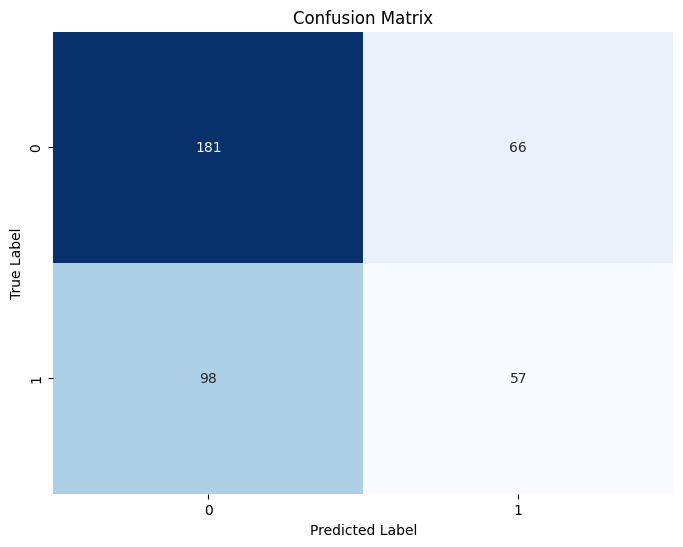

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [45]:
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       247
           1       0.46      0.37      0.41       155

    accuracy                           0.59       402
   macro avg       0.56      0.55      0.55       402
weighted avg       0.58      0.59      0.58       402



In [46]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))


Top 10 most important features:
                        Feature  Importance
34  creatinine.enzymatic.method    0.037512
35                     cystatin    0.034268
36                       sodium    0.033446
12               red.blood.cell    0.033340
11                   hematocrit    0.031313
6                      globulin    0.031021
26             neutrophil.count    0.030178
37                     chloride    0.030178
19         white.globulin.ratio    0.030167
28                     platelet    0.029933


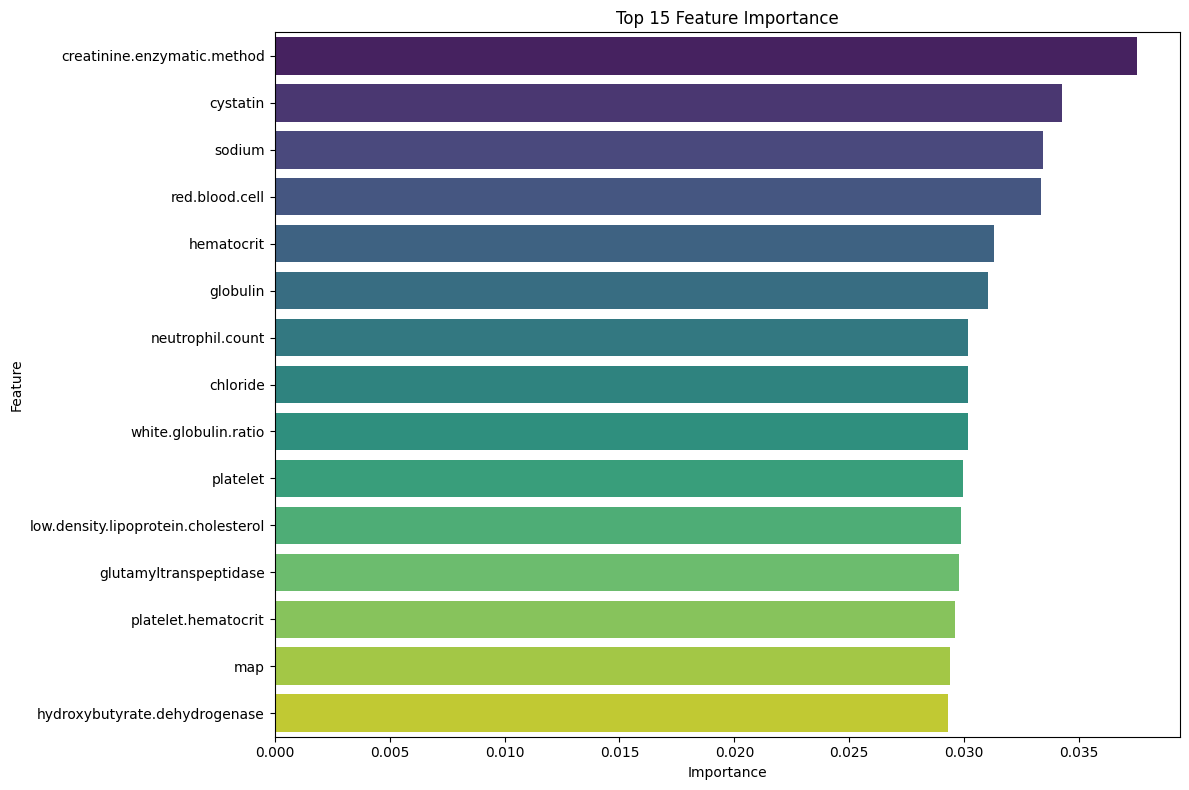

In [47]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

In [48]:
print("\nComparison with the paper's results:")
paper_f1_score = 0.4672

print(f"Paper's reported F1 score: {paper_f1_score:.4f}")
print(f"Our F1 score: {f1:.4f}")
print(f"Difference: {f1 - paper_f1_score:.4f}")

if abs(f1 - paper_f1_score) < 0.05:
    print("Your imputation method performs similarly to the I-NAA method from the paper,")
    print("which suggests the results are now in a realistic range after removing data leakage.")
elif f1 > paper_f1_score:
    print("Your imputation method appears to outperform the I-NAA method from the paper!")
else:
    print("Your imputation method performs slightly below the I-NAA method from the paper.")



Comparison with the paper's results:
Paper's reported F1 score: 0.4672
Our F1 score: 0.4101
Difference: -0.0571
Your imputation method performs slightly below the I-NAA method from the paper.
